# Reproducing Figures
This notebook demonstrates the steps required to reproduce the figures presented in the paper. Follow the instructions below to ensure the environment and data are properly set up.

# Notes for Reproducibility
+ Ensure that the same data and parameter values are used as described in the model

# 1. Prerequisites
**This code block will use the required packages needed to make the figures, and the julia file for processing data and visualization**

In [1]:
# Import necessary packages
using HDF5
using PyPlot
using Statistics
# Import necessary julia file
include("PostProcess.jl");

# 2. Data Preparation
**The following code will require the parameters used in the model to be defined, and the path to the data**
- range of ice shell thickenss
- range of wavelength
- amplitude
- gravity of icy moon
- data path

Note: the units must match the parameter defined in model

In [2]:
# Define your ice shell thickness range
ice_shell_thickness_range = range(5.0,60.0,15)
# Define your wavelength range
wavelength_range = range(5.0,300.0,14)  
# Define the amplitude value
amplitude = 20.0  
# Define gravity
gravity = 0.113 
# Define the data file path
folder_name = "Model_Outputs/"
# Define the output file path
output_path = folder_name*"_combined_output.hdf5";

# 3. Post-process Data 
**The following code will process the data for visualization**

In [35]:
combine_hdf5_files(ice_shell_thickness_range,wavelength_range,amplitude,gravity,output_path,folder_name)
fname = output_path
fid = h5open(fname,"r")
# Reading Data from file
modeldata = fid["Combined Model Run"];
# Uncomment the following code if you wish to display the contents 
for obj in modeldata
     data = read(obj)
     println(obj)
     display(data)
end
# Accessing contents and defining contents needed
Wavelength = read(modeldata,"Wavelength");
Ice_shell = read(modeldata, "Ice Shell Thickness");
Time_halfspace = read(modeldata,"Viscous Relaxation Time(Half-Space)");
Time_rel = read(modeldata,"Viscous Relaxation Time(Model)");
Time_thickening = read(modeldata, "Thickening Time");
Time_thickening_fit = read(modeldata, "Fitted Thickening Time");
Time_rel_fit = read(modeldata, "Fitted Viscous Relaxation Time");
# Close file
close(fid)
# Defining t'
t_prime = Time_rel_fit./Time_thickening_fit;

Finished Saving Data into a HDF5 File
HDF5.Dataset: /Combined Model Run/Fitted Thickening Time (file: Model_Outputs/_combined_output.hdf5 xfer_mode: 0)


14×15 Matrix{Float64}:
      1.57936e5       5.1757e5   …  2.16697e7  3.24061e7  4.92012e7
      1.72901e5       5.0493e5      1.86494e7  2.27072e7  2.47675e7
      1.92021e5       5.27017e5     1.81825e7  2.10619e7  2.44211e7
      2.01871e5       5.35102e5     1.78027e7  2.09289e7  2.36983e7
      2.10147e5       5.39882e5     1.75649e7  2.04944e7  2.34776e7
 221310.0        554118.0        …  1.73841e7  2.04329e7  2.33452e7
      2.27961e5       5.70436e5     1.74699e7  2.02016e7  2.32141e7
      2.34234e5       5.82871e5     1.74241e7  2.02066e7  2.29522e7
      2.39527e5       5.98887e5     1.74587e7  2.02133e7  2.29662e7
 245006.0             6.15116e5     1.74912e7  2.01226e7  2.29973e7
      2.48803e5       6.24763e5  …  1.73854e7  2.01096e7  2.30154e7
 254569.0             6.3349e5      1.75298e7  2.01405e7  2.30652e7
      2.58737e5       6.34867e5     1.75443e7  2.02705e7  2.31044e7
      2.65207e5       6.41955e5     1.75155e7  2.02726e7  2.30197e7

HDF5.Dataset: /Combined Model Run/Fitted Viscous Relaxation Time (file: Model_Outputs/_combined_output.hdf5 xfer_mode: 0)


14×15 Matrix{Float64}:
  11732.3         4589.2        …    493.244    464.483    433.18
      1.52729e5  48031.2             851.037    751.702    669.108
      5.68862e5      1.38424e5      1566.52    1332.44    1152.5
      8.15805e5      2.42032e5      2663.62    2217.56    1876.64
      1.12336e6      2.70704e5      4157.31    3416.42    2858.12
      8.37489e5      5.09475e5  …   6036.31    4948.91    4106.39
      8.48835e5      6.18626e5      8309.15    6780.6     5609.33
      8.75022e5      7.67657e5     10941.4     8907.6     7365.46
 881964.0            8.97882e5     13961.2    11357.7     9354.24
      8.8888e5       1.08074e6     17340.9    14091.6    11591.0
      8.86835e5      1.52324e6  …  21187.8    17182.2    14130.8
 895637.0            1.89113e6     25454.9    20569.1    16907.1
      8.92226e5      2.3027e6      30116.8    24355.1    19958.4
      8.92833e5      2.50166e6     35161.8    28451.8    23288.5

HDF5.Dataset: /Combined Model Run/Ice Shell Thickness (file: Model_Outputs/_combined_output.hdf5 xfer_mode: 0)


15-element Vector{Float64}:
  5000.0
  8928.57142857143
 12857.142857142857
 16785.714285714286
 20714.285714285714
 24642.85714285714
 28571.428571428572
 32500.0
 36428.57142857143
 40357.142857142855
 44285.71428571428
 48214.28571428572
 52142.857142857145
 56071.42857142857
 60000.0

HDF5.Dataset: /Combined Model Run/Thickening Time (file: Model_Outputs/_combined_output.hdf5 xfer_mode: 0)


14×15 Matrix{Float64}:
 1.4465e5        4.40041e5  …   9.07422e6   1.20919e7   2.48652e7
 1.69077e5       4.68851e5     -2.9395e7   -2.88024e7  -2.17105e7
 1.85444e5       5.06373e5     -3.31825e7  -1.96203e7  -1.863e7
 1.92584e5       5.19288e5     -6.28881e8  -5.41262e7  -3.05085e7
 1.97958e5       5.2441e5       3.23068e7   1.08535e8  -2.30641e8
 1.98957e5       5.37691e5  …   2.06081e7   3.08426e7   6.19872e7
 1.97277e5       5.52576e5      1.71866e7   2.24443e7   3.04487e7
 1.97318e5  564829.0            1.56459e7   1.9067e7    2.4442e7
 1.98018e5       5.77281e5      1.47384e7   1.77005e7   2.13353e7
 1.99428e5       5.88335e5      1.42103e7   1.71468e7   1.99336e7
 2.00194e5       5.98202e5  …   1.40285e7   1.62511e7   1.89909e7
 2.04999e5       6.04536e5      1.40547e7   1.61374e7   1.8345e7
 2.08459e5  603758.0            1.39845e7   1.58441e7   1.79914e7
 2.14971e5       6.0931e5       1.39176e7   1.58898e7   1.79755e7

HDF5.Dataset: /Combined Model Run/Viscous Relaxation Time(Half-Space) (file: Model_Outputs/_combined_output.hdf5 xfer_mode: 0)


14×15 Matrix{Float64}:
 847.934   847.934   847.934   847.934   …  847.934   847.934   847.934
 153.099   153.099   153.099   153.099      153.099   153.099   153.099
  84.1462   84.1462   84.1462   84.1462      84.1462   84.1462   84.1462
  58.0166   58.0166   58.0166   58.0166      58.0166   58.0166   58.0166
  44.2697   44.2697   44.2697   44.2697      44.2697   44.2697   44.2697
  35.7894   35.7894   35.7894   35.7894  …   35.7894   35.7894   35.7894
  30.0358   30.0358   30.0358   30.0358      30.0358   30.0358   30.0358
  25.8759   25.8759   25.8759   25.8759      25.8759   25.8759   25.8759
  22.7281   22.7281   22.7281   22.7281      22.7281   22.7281   22.7281
  20.2631   20.2631   20.2631   20.2631      20.2631   20.2631   20.2631
  18.2805   18.2805   18.2805   18.2805  …   18.2805   18.2805   18.2805
  16.6513   16.6513   16.6513   16.6513      16.6513   16.6513   16.6513
  15.2887   15.2887   15.2887   15.2887      15.2887   15.2887   15.2887
  14.1322   14.1322   14.1322 

HDF5.Dataset: /Combined Model Run/Viscous Relaxation Time(Model) (file: Model_Outputs/_combined_output.hdf5 xfer_mode: 0)


14×15 Matrix{Float64}:
 11208.3        34255.5        …  1.63707e6  2.0093e6   3.02256e6
 71196.8        38906.2           1.13372e6  1.36115e6  1.44334e6
     1.63116e5  70235.4           1.02828e6  1.35812e6  1.43147e6
     2.45137e5      1.27802e5     1.03353e6  1.21648e6  1.36909e6
     3.29008e5      1.93896e5     1.03123e6  1.1523e6   1.4143e6
     4.60701e5      2.38398e5  …  1.01248e6  1.21996e6  1.33899e6
     5.53354e5      3.04498e5     1.02449e6  1.15915e6  1.30483e6
     6.30497e5      3.65547e5     1.07e6     1.14701e6  1.31658e6
     6.91527e5      4.45238e5     1.01425e6  1.18848e6  1.30096e6
     7.53487e5      5.34381e5     1.065e6    1.20083e6  1.3896e6
     8.13597e5      5.99445e5  …  1.07115e6  1.22136e6  1.40115e6
     8.77309e5      6.66602e5     1.13442e6  1.25783e6  1.30488e6
     9.38764e5      7.06617e5     1.08626e6  1.24009e6  1.41901e6
     1.00634e6      7.71593e5     1.08344e6  1.1763e6   1.38933e6

HDF5.Dataset: /Combined Model Run/Wavelength (file: Model_Outputs/_combined_output.hdf5 xfer_mode: 0)


14-element Vector{Float64}:
   5000.0
  27692.307692307695
  50384.61538461539
  73076.92307692308
  95769.23076923078
 118461.53846153847
 141153.84615384616
 163846.15384615384
 186538.46153846156
 209230.76923076922
 231923.07692307694
 254615.38461538462
 277307.6923076923
 300000.0

In [36]:
t_prime

14×15 Matrix{Float64}:
 0.0742852  0.00886682  0.00237478  0.000983248  …  1.43332e-5   8.80426e-6
 0.883336   0.0951245   0.0189873   0.00561456      3.31041e-5   2.70155e-5
 2.9625     0.262655    0.0540206   0.0159319       6.3263e-5    4.71929e-5
 4.04123    0.452309    0.102233    0.0314093       0.000105957  7.91888e-5
 5.34559    0.501413    0.163361    0.0508509       0.0001667    0.000121738
 3.78424    0.919433    0.236951    0.0734375    …  0.000242203  0.000175898
 3.72359    1.08448     0.323052    0.0996362       0.000335647  0.000241634
 3.73568    1.31703     0.390436    0.129497        0.000440826  0.000320904
 3.6821     1.49925     0.460909    0.160954        0.000561891  0.000407304
 3.62799    1.75698     0.491947    0.194436        0.000700289  0.000504017
 3.56441    2.43811     0.474785    0.235472     …  0.000854427  0.000613971
 3.51825    2.98526     0.597303    0.269984        0.00102128   0.000733011
 3.4484     3.62705     0.627165    0.318132        0.001

# 4. Generating Figures
**The following code will make the figures for $t'$, $t_{relaxation}$, and $t_{thickening}$**

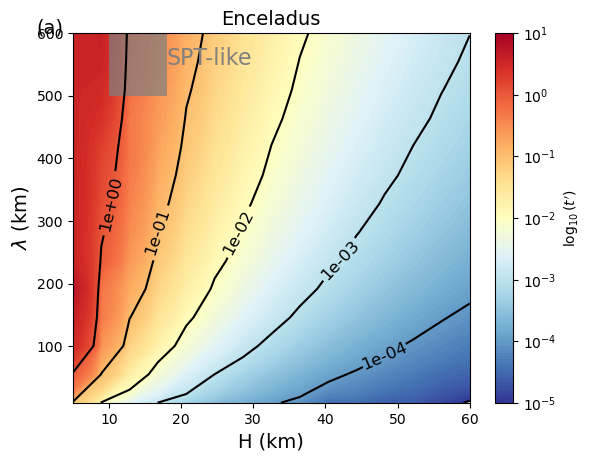

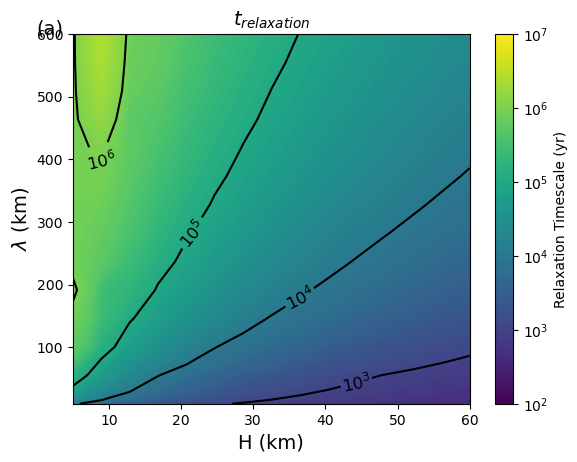

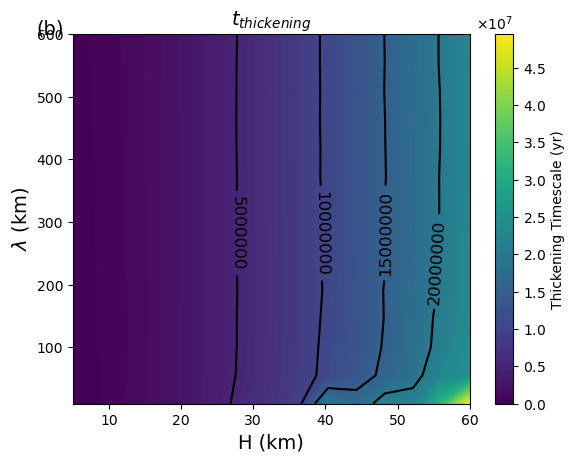

In [37]:
# Importing matplotlib variables
cm = PyPlot.matplotlib[:cm]
LogNorm = PyPlot.matplotlib[:colors][:LogNorm]
ticker = PyPlot.matplotlib[:ticker]

### Plot for t' ###
## starts here ##
figure()
# Smooth-looking contour plot in the background
levs = exp10.(range(-5,1,length=128))
cs1=contourf(Ice_shell/1e3,(2*Wavelength)/1e3,t_prime,levs,norm=LogNorm(),vmin=1e-5,vmax=1e1,cmap=cm.RdYlBu_r)
levs1 = exp10.([-5,-4,-3,-2,-1,0,1])
# Adding contour lines in the foreground
cs = contour(Ice_shell/1e3,(2*Wavelength)/1e3,t_prime,levs1,norm=LogNorm(),colors="k")
clabel(cs,inline=true,fmt="%2.e",colors="k",fontsize=12)
title("Enceladus",fontsize=14)
colorbar(cs1,ticks=levs1,label=L"\log_{10}(t')")
gca().yaxis.set_label_position("left")
gca().set_ylabel(L"\lambda"*" (km)",fontsize=14)
gca().set_xlabel("H (km)",fontsize=14,rotation=0)
# Highlight region with a square
x0,y0 = 10,600  # replace with the coordinates of the bottom-left corner
width,height = 8,-100  # replace with the dimensions of the square
# Making square
gca().add_patch(PyPlot.matplotlib[:patches][:Rectangle](
        (x0, y0),
        width,
        height,
        fill=true,
        facecolor="gray",
        alpha=0.7,
        linewidth=5))
# Making texts
annotate("SPT-like", 
        xy=(x0,y0), 
        xytext=(x0+8,y0-50), 
        fontsize=16, 
        color="gray")
annotate("(a)", 
        xy=(x0,y0), 
        xytext=(x0-10,y0), 
        fontsize=14, 
        color="black")
show()
## ends here ##

### Plot for viscous relaxation ###
## starts here ##
figure()
# smooth background contour plot:
levs = exp10.(range(2, stop=7, length=100))
cs = contourf(Ice_shell/1e3,(2*Wavelength)/1e3,Time_rel_fit,levs,norm=LogNorm(),vmin=1e2,vmax=1e7)
# contour levels to highlight
levs1 = exp10.([2,3,4,5,6,7])
cs1 = contour(Ice_shell/1e3,(2*Wavelength)/1e3,Time_rel_fit,levs1,norm=LogNorm(),colors="k")
# scientific notation formatter
fmt = PyPlot.matplotlib[:ticker][:LogFormatterSciNotation]()
labels = Dict()
for level in cs1.levels
    labels[level] = fmt(level)
end
clabel(cs1,inline=true,fmt=labels,colors="k",fontsize=12)
colorbar(cs,ticks=levs1,label="Relaxation Timescale (yr)")
title(L"t_{relaxation}",fontsize=14)
gca().yaxis.set_label_position("left")
gca().set_ylabel(L"\lambda"*" (km)",fontsize=14)
gca().set_xlabel("H (km)",fontsize=14,rotation=0)
# Making text
annotate("(a)", 
        xy=(x0,y0), 
        xytext=(x0-10,y0), 
        fontsize=14, 
        color="black")
show()
## ends here ##

### Plot for thickening ###
## starts here ##
figure()
# Define the 3 levels to highlight
highlight_levels = [0.5e7,1.0e7,1.5e7,2.0e7]
# Plot all 32 levels with muted lines
cs = contour(Ice_shell/1e3, (2*Wavelength)/1e3, Time_thickening_fit,levels=100)
# Plot only the 3 highlight levels with a thicker line or different color
highlight_cs = contour(Ice_shell/1e3,(2*Wavelength)/1e3,Time_thickening_fit, colors="k",levels=highlight_levels)
# Fill the contours with the colormap
contourf(cs,cmap=get_cmap("viridis"))
# Add title and contour labels
title(L"t_{thickening}",fontsize=14)
clabel(highlight_cs,inline=true,fmt="%1.0f",colors="k",fontsize=12)  # Labels for highlighted levels
# Add the colorbar
cbar = colorbar(label="Thickening Timescale (yr)", location="right")
# Set the ScalarFormatter for the colorbar to use scientific notation
formatter = ticker.ScalarFormatter(useMathText=true)
formatter.set_scientific(true)
formatter.set_powerlimits((-2, 2))
formatter.set_useOffset(false)
cbar.ax.yaxis.set_major_formatter(formatter)
# Set labels and formatting
gca().yaxis.set_label_position("left")
gca().set_ylabel(L"\lambda"*" (km)", fontsize=14)
gca().set_xlabel("H (km)", fontsize=14, rotation=0)

# Making text
annotate("(b)", 
        xy=(x0,y0), 
        xytext=(x0-10,y0), 
        fontsize=14, 
        color="black")
show()
## ends here ##